Code My_CLR of 12.4.23

# Defining and loading data

### Preprocessing:

Center Jets

In [38]:
# returns image momenta for the centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

def centre_jet(x, y, weights):
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid
    return x, y

In [2]:
#!/bin/env python3.7

# load standard python modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
#from modules.jet_augs import rotate_jets, distort_jets, rescale_pts, crop_jets, translate_jets, collinear_fill_jets 
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss
from modules.perf_eval import get_perf_stats, linear_classifier_test 
from modules.fcn_linear import fully_connected_linear_network

# importing the torch modules
from modules.my_jet_augs import rotate_jets, distort_jets, rescale_pts, crop_jets, translate_jets, collinear_fill_jets, collinear_fill_jets_new

# import args from extargs.py file
import My_extargs as args

#starting counter
t0 = time.time()

# initialise logfile
logfile = open("/remote/gpu05/rueschkamp/outputs_from_queue/CLR/Debugging/my_debug_logfile.txt", "a" )
print( "logfile initialised"   )

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print( "device: " + str( device )    )

#loading in data ------------------------------------------------------------

#coverter functions -----------------------------

def pT(px,py):
    pT = np.sqrt( px**2 + py**2 )
    return pT

# Calculate pseudorapidity of pixel entries
def eta(pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate phi of the pixel entries (in range [-pi,pi])
# phis are returned in radians, np.arctan(0,0)=0 -> zero constituents set to -np.pi
def phi (px, py):
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

#doing the convertions
def converter(data_path,num_jets):

    data_frame = pd.read_hdf(data_path, key='table', start=0, stop=num_jets)
    #give names
    max_const = args.n_constit
    feat_list =  ["E","PX","PY","PZ"] 
    cols = ["{0}_{1}".format(feature,constit) for feature in feat_list for constit in range(max_const)]
    #reshape
    vec4 = np.expand_dims(data_frame[cols],axis=-1).reshape(-1, len(feat_list), max_const)
    #getting p_vec and E
    E  = vec4[:,0,:]
    pxs   = vec4[:,1,:]
    pys   = vec4[:,2,:]
    pzs   = vec4[:,3,:]
    # get pT,eta,phi
    pTs = pT(pxs,pys)
    etas = eta(pTs,pzs)
    phis = phi(pxs,pys)
    #get them together
    jet_data = np.stack([pTs,etas,phis],axis = 1)
    labels = data_frame["is_signal_new"].to_numpy()
    return torch.Tensor(jet_data).to(device) , torch.Tensor(labels).to(device)

def converter_plus(data_path,num_jets):

    data_frame = pd.read_hdf(data_path, key='table', start=0, stop=num_jets)
    #give names
    max_const = args.n_constit
    feat_list =  ["E","PX","PY","PZ"] 
    cols = ["{0}_{1}".format(feature,constit) for feature in feat_list for constit in range(max_const)]
    #reshape
    vec4 = np.expand_dims(data_frame[cols],axis=-1).reshape(-1, len(feat_list), max_const)
    #getting p_vec and E
    E  = vec4[:,0,:]
    pxs   = vec4[:,1,:]
    pys   = vec4[:,2,:]
    pzs   = vec4[:,3,:]
    # get pT,eta,phi
    pTs = pT(pxs,pys)
    etas = eta(pTs,pzs)
    phis = phi(pxs,pys)

    for i in range(etas.shape[0]):
        etas[i,:], phis[i,:] = centre_jet( etas[i,:], phis[i,:], pTs[i,:] )

    #get them together
    jet_data = np.stack([pTs,etas,phis],axis = 1)
    labels = data_frame["is_signal_new"].to_numpy()
    return torch.Tensor(jet_data).to(device) , torch.Tensor(labels).to(device)


def converter_lorenz(data_path,num_jets):

    data_frame = pd.read_hdf(data_path, key='table', start=0, stop=num_jets)
    #give names
    max_const = args.n_constit
    feat_list =  ["E","PX","PY","PZ"] 
    cols = ["{0}_{1}".format(feature,constit) for feature in feat_list for constit in range(max_const)]
    #reshape
    vec4 = np.expand_dims(data_frame[cols],axis=-1).reshape(-1, len(feat_list), max_const)
    #getting p_vec and E
    E  = vec4[:,0,:]
    pxs   = vec4[:,1,:]
    pys   = vec4[:,2,:]
    pzs   = vec4[:,3,:]
    # get pT,eta,phi
    pTs = pT(pxs,pys)
    etas = eta(pTs,pzs)
    phis = phi(pxs,pys)

    for i in range(etas.shape[0]):
        etas[i,:], phis[i,:] = centre_jet( etas[i,:], phis[i,:], pTs[i,:] )

    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi

    #get them together
    jet_data = np.stack([pTs,etas,phis],axis = 1)
    labels = data_frame["is_signal_new"].to_numpy()
    return torch.Tensor(jet_data).to(device) , torch.Tensor(labels).to(device)

#defining classes ------------------------------------------

class My_Dataset(Dataset):
    def __init__(self, training_path , validation_path, test_path, usage, transform=None, target_transform=None, number_of_jets = None):
        #getting data
        num_jets = number_of_jets
        if number_of_jets == None:
            num_jets = 1e3
        
        train_data , train_labels = converter_plus(training_path,int( num_jets) )
        #val_data , val_labels = converter(validation_path, int(num_jets*args.ratio) ) # for larger datasets below two time *args.ratio in the LCT part!
        #test_data, test_labels = converter(test_path,int(num_jets*args.ratio))
        val_data , val_labels = converter_plus(validation_path, int(num_jets) )
        test_data, test_labels = converter_plus(test_path,int(num_jets))
        
        # re-scale test data, for the training data this will be done on the fly due to the augmentations
        test_data = rescale_pts( test_data )
        val_data = rescale_pts(val_data)

        if usage== "training" :
            self.labels = train_labels
            self.data = train_data
        elif usage=="validation":
            self.labels = val_labels
            self.data = val_data
        elif usage=="testing":
            self.labels = test_labels
            self.data = test_data
        elif usage=="LCT_train":
            self.labels = test_labels[:int(num_jets*(1-args.ratio))]
            self.data = test_data[:int(num_jets*(1-args.ratio))]
        elif usage=="LCT_test":
            self.labels = test_labels[int(num_jets*(args.ratio)):]
            self.data = test_data[int(num_jets*(args.ratio)):]
        else:
            print("check usage!")

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]

        return data, label
    
#starting training loader --------------------------------------


training_set = My_Dataset(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"training")

dl_training = DataLoader(training_set,batch_size=args.batch_size, shuffle=True)

t1 = time.time()
print( "time taken to load and preprocess data: "+str( np.round( t1-t0, 2 ) ) + " seconds"    )


#initializing the network 
input_dim = 3 

net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )
# send network to device
net.to( device )

"""
# set up results directory -----------------------------------------------------------
base_dir = "/remote/gpu05/rueschkamp/outputs_from_queue/" 
expt_tag = "Mytry1"
expt_dir = base_dir + "My_experiments/" + expt_tag + "/"
# check if experiment already exists
if os.path.isdir(expt_dir):
    sys.exit("ERROR: experiment already exists, don't want to overwrite it by mistake")
else:
    os.makedirs(expt_dir)
    """



logfile initialised
device: cuda


/remote/gpu01/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/remote/gpu01/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVIDIA GeForce GTX TITAN which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


time taken to load and preprocess data: 3.15 seconds


'\n# set up results directory -----------------------------------------------------------\nbase_dir = "/remote/gpu05/rueschkamp/outputs_from_queue/" \nexpt_tag = "Mytry1"\nexpt_dir = base_dir + "My_experiments/" + expt_tag + "/"\n# check if experiment already exists\nif os.path.isdir(expt_dir):\n    sys.exit("ERROR: experiment already exists, don\'t want to overwrite it by mistake")\nelse:\n    os.makedirs(expt_dir)\n    '

# Training Loop CLR

In [3]:
# THE TRAINING LOOP -----------------------------------------------------------

print( "starting training loop, running for " + str( args.n_epochs ) + " epochs"    )
print( "---"    )

losses = []

# the loop
#for epoch in range( args.n_epochs ):
for epoch in range( 21 ):
    # initialise timing stats
    te0 = time.time()
    
    # initialise lists to store batch stats
    loss_align_e = []
    loss_uniform_e = []
    losses_e = []

    # initialise timing stats
    td1 = 0
    td2 = 0
    td3 = 0
    td4 = 0
    td5 = 0
    td6 = 0
    td7 = 0
    td8 = 0
    print("epoch: ",epoch)

    # the inner loop goes through the dataset batch by batch
    # augmentations of the jets are done on the fly
    for i, (data, labels) in enumerate(dl_training):
        net.optimizer.zero_grad()
        x_i = data
        
        
        time1 = time.time()
        # print(x_i.shape) # checking what Tensor is fed into the augmentations
        #x_i = rotate_jets( x_i )
        x_j = x_i.clone()
        if args.rot:
            x_j = rotate_jets( x_j )
        time2 = time.time()

        if (args.cf) == False :
            x_j = collinear_fill_jets_new( x_j )
            x_j = collinear_fill_jets_new( x_j ) #Why two times?
        time3 = time.time()

        if args.ptd:
            x_j = distort_jets( x_j, strength=args.ptst, pT_clip_min=args.ptcm )
        time4 = time.time()

        if args.trs:
            x_j = translate_jets( x_j, width=args.trsw )
            x_i = translate_jets( x_i, width=args.trsw ) # Why are both translated?
        time5 = time.time()
        
        x_i = rescale_pts( x_i )
        x_j = rescale_pts( x_j )
        x_i = x_i.transpose(1,2)
        x_j = x_j.transpose(1,2)
        time6 = time.time()

        z_i  = net(x_i, use_mask=args.mask, use_continuous_mask=False) #dim: x_i = torch.Size([104, 50, 3]) and z_i = torch.Size([104, 1000])
        z_j = net(x_j, use_mask=args.mask, use_continuous_mask=False)
        time7 = time.time()

        # calculate the alignment and uniformity loss for each batch --------------------NEW 19.4
        if epoch%10==0:
            loss_align = align_loss( z_i, z_j )
            loss_uniform_zi = uniform_loss( z_i )
            loss_uniform_zj = uniform_loss( z_j )
            loss_align_e.append( loss_align.detach().cpu().numpy() )
            loss_uniform_e.append( ( loss_uniform_zi.detach().cpu().numpy() + loss_uniform_zj.detach().cpu().numpy() )/2 )
        time8 = time.time()
        #-------------------------------------------


        # compute the loss, back-propagate, and update scheduler if required
        loss = contrastive_loss( z_i, z_j, args.temperature ).to( device )
        loss.backward()
        net.optimizer.step()
        losses_e.append( loss.detach().cpu().numpy() )
        
        time9 = time.time()

        # update timiing stats
        td1 += time2 - time1
        td2 += time3 - time2
        td3 += time4 - time3
        td4 += time5 - time4
        td5 += time6 - time5
        td6 += time7 - time6
        td7 += time8 - time7
        td8 += time9 - time8

    loss_e = np.mean( np.array( losses_e ) )
    losses.append( loss_e )


#np.save("/remote/gpu05/rueschkamp/outputs_from_queue/CLR/clr_losses.npy", losses )

print(x_j.shape )
print(z_j.shape )

te1= time.time()

print( "JETCLR TRAINING DONE, time taken: " + str( np.round( te1-te0 , 2 ) )    )
print( f"total time taken: {round( te1-te0, 1 )}s, augmentation: {round(td1+td2+td3+td4+td5,1)}s, forward {round(td6, 1)}s, backward {round(td8, 1)}s, other {round(te1-te0-(td1+td2+td3+td4+td6+td7+td8), 2)}s", flush=True, file=logfile )
print("collinier Fill: " + str( np.round( td2 , 2 )))


starting training loop, running for 100 epochs
---
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
torch.Size([104, 50, 3])
torch.Size([104, 1000])
JETCLR TRAINING DONE, time taken: 5.06
collinier Fill: 0.0


### Saving the Model

In [6]:
tms0 = time.time()
torch.save(net.state_dict(),"/remote/gpu05/rueschkamp/outputs_from_queue/CLR/Debugging/Model.pt")
tms1 = time.time()
print( f"time taken to save model: {round( tms1-tms0, 1 )}s" )

time taken to save model: 2.2s


## Checking if the projection works


In [26]:
cos = nn.CosineSimilarity(dim=1,eps=1e-6)

print(torch.norm(z_i[0]),torch.norm(z_j[0]))

z0 = F.normalize(z_i[0], dim=-1)
zj0 = F.normalize(z_j[0],dim=-1)
z1 = F.normalize(z_i[1], dim=-1)
print(torch.norm(z0),torch.norm(zj0),torch.norm(z1))


cos_dist_pair = torch.sqrt(torch.matmul(z0, zj0.T)**2)
cos_dist_random = torch.sqrt(torch.matmul(z0, z1.T)**2)

print("pairs: ", cos_dist_pair, " random: " , cos_dist_random)
#print("pairs: ", cos(z0,zj0), " random: " , cos(z0,z1))

#print(cos(z_i[0],z_j[0]))

tensor(30.7290, device='cuda:0', grad_fn=<CopyBackwards>) tensor(24.5296, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(1., device='cuda:0', grad_fn=<CopyBackwards>) tensor(1.0000, device='cuda:0', grad_fn=<CopyBackwards>) tensor(1., device='cuda:0', grad_fn=<CopyBackwards>)
pairs:  tensor(0.7372, device='cuda:0', grad_fn=<SqrtBackward0>)  random:  tensor(0.3150, device='cuda:0', grad_fn=<SqrtBackward0>)


## Plot the training loss:

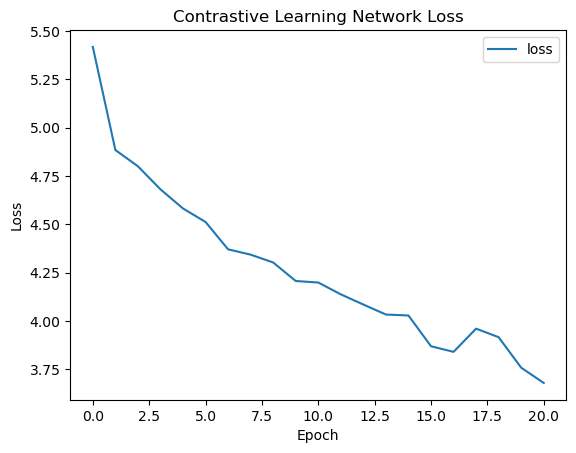

In [4]:
# Plot the training loss
x = np.linspace(0,21-1,21)

plt.plot(x, losses, label = "loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Learning Network Loss')
plt.legend()
plt.show()

In [5]:
print(x_i.shape)

torch.Size([104, 50, 3])


# Testing the Mapping of rotations


In [46]:
def rotate_jets_0to2pi(batch):
    '''
    Input: batch of jets, shape (batchsize, 3, n_constit)
    dim 1 ordering: (pT, eta, phi)
    Output: batch of jets rotated independently in eta-phi, same shape as input
    '''
    device = batch.device
    batch_size = batch.size(0)

    rot_angle = torch.linspace(0, 2 * np.pi, batch_size)
    c = torch.cos(rot_angle)
    s = torch.sin(rot_angle)
    o = torch.ones_like(rot_angle)
    z = torch.zeros_like(rot_angle)

    #print(o.shape)

    rot_matrix = torch.stack([
    torch.stack([o, z, z], dim=0),
    torch.stack([z, c, -s], dim=0),
    torch.stack([z, s, c], dim=0)], dim=1) # (3, 3, batch_size]

    rot_matrix = rot_matrix.to(device)

    print(rot_matrix.device)
    print(batch.device)

    #print(rot_matrix[:,:,0])

    return torch.einsum('ijk,lji->ilk', batch, rot_matrix)




for i, (data, labels) in enumerate(dl_training):
    original_batch = data
    print(labels[0])
    break

print(original_batch.shape)

original_jet = original_batch[0]

print(original_jet.shape)

standard_batch = original_jet.unsqueeze(0).repeat(128, 1, 1)

#print(standard_batch.device)

rotated_batch = rotate_jets_0to2pi(standard_batch)

with torch.no_grad():
        
    x_i = standard_batch
    x_j = rotated_batch

    x_i = x_i.transpose(1,2)
    x_j = x_j.transpose(1,2)

    #x_i = torch.Tensor( x_i ).transpose(1,2)#.to( device ) 
    #x_j =torch.Tensor( x_j ).transpose(1,2)#.to( device ) 

    #print(x_i.shape)

    point_on_sphere_i = net(x_i)
    point_on_sphere_j = net(x_j)


                #normalise it!
    point_on_sphere_i = F.normalize(point_on_sphere_i, dim=-1)
    point_on_sphere_j = F.normalize(point_on_sphere_j, dim=-1)

tensor(0., device='cuda:0')
torch.Size([128, 3, 50])
torch.Size([3, 50])
cuda:0
cuda:0


torch.Size([128, 1000])
torch.Size([1000])
torch.Size([128])


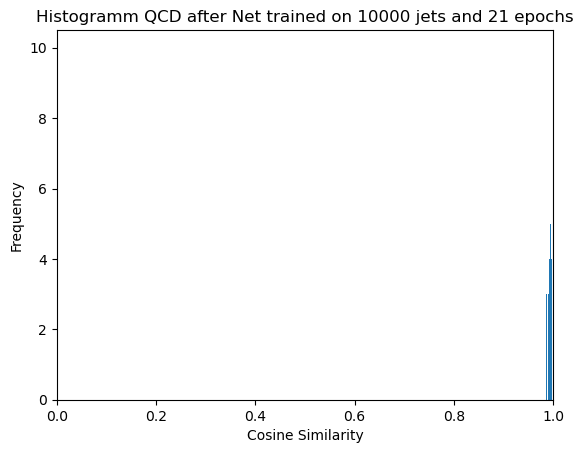

In [47]:
print(point_on_sphere_j.size())
print(point_on_sphere_i[0].size())

# Calculate cosine similarity between the first jet in the batch and all the others
cos_similarities = torch.nn.functional.cosine_similarity(point_on_sphere_i[0], point_on_sphere_j, dim=1)
print(cos_similarities.size())

# Plot a histogram of the cosine similarities
plt.hist(cos_similarities.cpu().numpy(), bins=50)
plt.title("Histogramm QCD after Net trained on 10000 jets and 21 epochs")
plt.xlabel('Cosine Similarity')
plt.xlim(0,1)
plt.ylabel('Frequency')
plt.show()


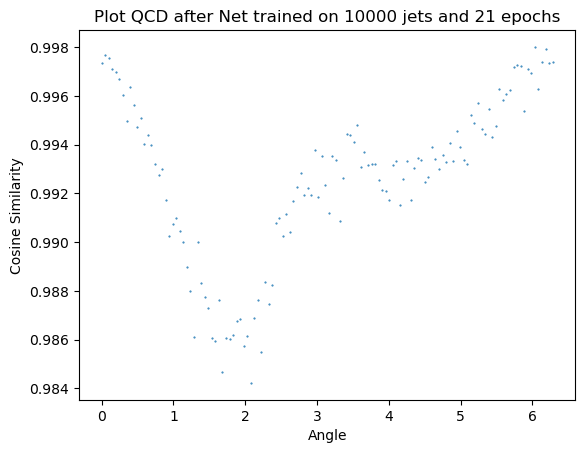

In [48]:
angles = torch.linspace(0,2*np.pi,128)

# Create the plot
plt.plot(angles.cpu().numpy(), cos_similarities.cpu().numpy(), '.', markersize=1)
plt.title("Plot QCD after net trained on 10000 jets and 21 epochs")
plt.xlabel('Angle')
plt.ylabel('Cosine Similarity')
plt.show()

### Now for top:

In [49]:
for i, (data, labels) in enumerate(dl_training):
    original_batch = data
    print(labels[2])
    break

print(original_batch.shape)

original_jet = original_batch[2]

print(original_jet.shape)

standard_batch = original_jet.unsqueeze(0).repeat(128, 1, 1)

rotated_batch = rotate_jets_0to2pi(standard_batch)

with torch.no_grad():
        
    x_i = standard_batch
    x_j = rotated_batch

    x_i = x_i.transpose(1,2)
    x_j = x_j.transpose(1,2)

    #print(x_i.shape)

    point_on_sphere_i = net(x_i)
    point_on_sphere_j = net(x_j)


                #normalise it!
    point_on_sphere_i = F.normalize(point_on_sphere_i, dim=-1)
    point_on_sphere_j = F.normalize(point_on_sphere_j, dim=-1)

tensor(1., device='cuda:0')
torch.Size([128, 3, 50])
torch.Size([3, 50])
cuda:0
cuda:0


torch.Size([128, 1000])
torch.Size([1000])
torch.Size([128])


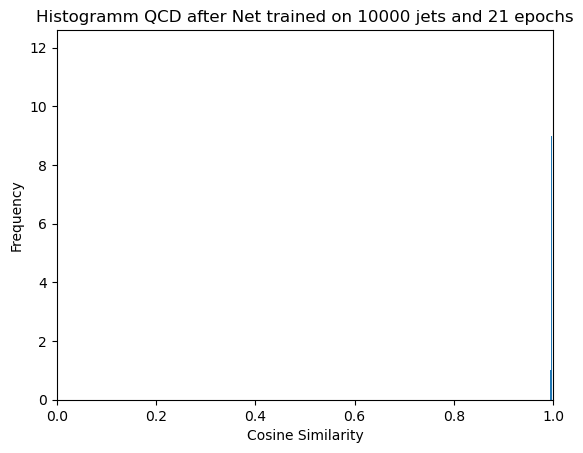

In [50]:
print(point_on_sphere_j.size())
print(point_on_sphere_i[0].size())

# Calculate cosine similarity between the first jet in the batch and all the others
cos_similarities = torch.nn.functional.cosine_similarity(point_on_sphere_i[0], point_on_sphere_j, dim=1)
print(cos_similarities.size())

# Plot a histogram of the cosine similarities
plt.hist(cos_similarities.cpu().numpy(), bins=50)
plt.title("Histogramm QCD after Net trained on 10000 jets and 21 epochs")
plt.xlabel('Cosine Similarity')
plt.xlim(0,1)
plt.ylabel('Frequency')
plt.show()


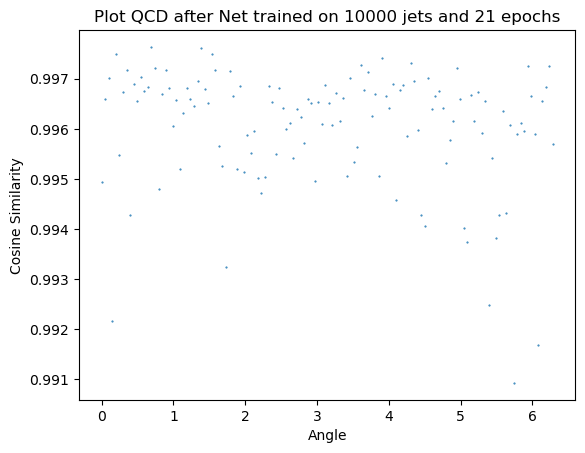

In [51]:
angles = torch.linspace(0,2*np.pi,128)

# Create the plot
plt.plot(angles.cpu().numpy(), cos_similarities.cpu().numpy(), '.', markersize=1)
plt.title("Plot QCD after Net trained on 10000 jets and 21 epochs")
plt.xlabel('Angle')
plt.ylabel('Cosine Similarity')
plt.show()

# Linear Classifier Test


### Loading Models


In [305]:
loading_model = True
if loading_model :
    # Create an instance of your model
    net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )

    # Load the saved state dictionary
    state_dict = torch.load("/remote/gpu05/rueschkamp/outputs_from_queue/CLR/Big_Model.pt")

    # Load the state dictionary into the model
    net.load_state_dict(state_dict)
    net.to(device)

In [5]:
from modules.fcn_linear import fully_connected_linear_network

linear_input_size = args.output_dim
linear_n_epochs = 750
linear_learning_rate = 0.001
linear_batch_size = 128
linear_opt = "adam"

#Dataloader Setup

data_LCT_train = My_Dataset(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"LCT_train",number_of_jets= 1e3/3)
data_LCT_test = My_Dataset(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"LCT_test",number_of_jets= 1e3/3)

print(len(data_LCT_test))

dl_LCT_training = DataLoader(data_LCT_train,batch_size=args.batch_size, shuffle=True)
dl_LCT_test = DataLoader(data_LCT_test,batch_size=args.batch_size, shuffle=False)

267


In [6]:
net.eval();

In [12]:
linear_model = fully_connected_linear_network( linear_input_size, 1, linear_opt, linear_learning_rate )
linear_model = linear_model.to(device)

criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
#sigmoid = nn.Sigmoid()
linear_learning_rate = 0.0001

# Utilize a named tuple to keep track of scores at each epoch
import collections # whats this???
model_hist = collections.namedtuple('Model','epoch loss')
model_loss = model_hist(epoch = [], loss = [])


def train(epochs, model, criterion, train_dataloader):
    try:
        c = model_loss.epoch[-1]
    except:
        c = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            # Zero the parameter gradients
            model.optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            # inputs = inputs.to(device)
            labels = labels.to(device)

            #     Stuff from earlier loop
            x_i = inputs
            time1 = time.time()

            x_i = x_i.transpose(1,2) #this should not be a thing lol WTF ______-----____
            
            #print(x_i.shape)
            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )


            outputs =model(point_on_sphere)
            #outputs = sigmoid(model(point_on_sphere))

            loss = criterion(outputs, labels.unsqueeze(-1).float())
            loss.backward()
            model.optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(loss.item())
        print(f"Epoch {epoch}: loss={epoch_loss:.4f}")
        

In [13]:
train(100,linear_model,criterion,dl_LCT_training) #is it fine to just transform the jets i trained the CLR on?

Epoch 0: loss=0.6782
Epoch 1: loss=0.6615
Epoch 2: loss=0.6350
Epoch 3: loss=0.6277
Epoch 4: loss=0.6676
Epoch 5: loss=0.6161
Epoch 6: loss=0.6597
Epoch 7: loss=0.6035
Epoch 8: loss=0.6494
Epoch 9: loss=0.6275
Epoch 10: loss=0.6091
Epoch 11: loss=0.6225
Epoch 12: loss=0.6733
Epoch 13: loss=0.6062
Epoch 14: loss=0.6012
Epoch 15: loss=0.6166
Epoch 16: loss=0.6018
Epoch 17: loss=0.5846
Epoch 18: loss=0.5974
Epoch 19: loss=0.6366
Epoch 20: loss=0.6281
Epoch 21: loss=0.5960
Epoch 22: loss=0.5734
Epoch 23: loss=0.5840
Epoch 24: loss=0.6091
Epoch 25: loss=0.6125
Epoch 26: loss=0.5945
Epoch 27: loss=0.6276
Epoch 28: loss=0.5981
Epoch 29: loss=0.6714
Epoch 30: loss=0.5771
Epoch 31: loss=0.6476
Epoch 32: loss=0.5399
Epoch 33: loss=0.5728
Epoch 34: loss=0.5440
Epoch 35: loss=0.5942
Epoch 36: loss=0.5980
Epoch 37: loss=0.6255
Epoch 38: loss=0.5560
Epoch 39: loss=0.5912
Epoch 40: loss=0.6053
Epoch 41: loss=0.6222
Epoch 42: loss=0.5643
Epoch 43: loss=0.5977
Epoch 44: loss=0.6041
Epoch 45: loss=0.572

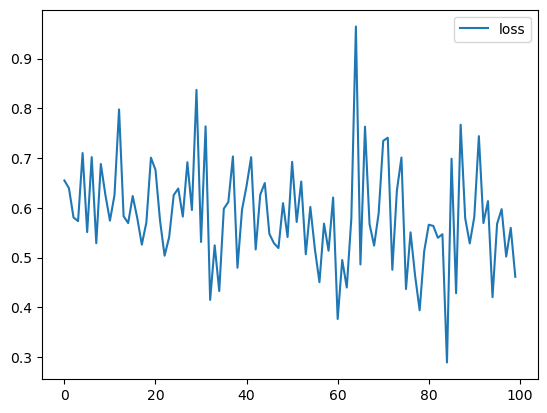

In [14]:
x = np.linspace(0, 100-1 , 100)
plt.plot(x, model_loss.loss, label="loss")
plt.legend()
plt.show()

In [15]:
def calculate_errors(CLR_model,LCT_model, dataloader):
    errors = []
    output =[]
    #print(CLR_model)
    #print(LCT_model)
    CLR_model.eval() # set model to evaluation mode
    LCT_model.eval()
    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, labels in dataloader:
            
            x_i = inputs

            x_i =  x_i.transpose(1,2)
            
            point_on_sphere = CLR_model(x_i, use_mask=args.mask, use_continuous_mask=args.cmask)
            outputs = LCT_model(point_on_sphere).to(torch.device("cpu"))
            
            output.extend(outputs)

    return np.array(output)

def calculate_errors_old(model, criterion, dataloader):
    errors = []
    model.eval() # set model to evaluation mode
    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, labels in dataloader:
            
            x_i = inputs

            x_i =  x_i.transpose(1,2)

            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )

            #point_on_sphere = F.normalize(point_on_sphere, dim=-1)

            #outputs = sigmoid(model(point_on_sphere))
            outputs = model(point_on_sphere)

            criterion = nn.BCEWithLogitsLoss(reduction = 'none')
            loss = criterion(outputs.to(torch.device("cpu")),labels.unsqueeze(-1).to(torch.device("cpu")).float()) 
            errors.extend(loss.to(torch.device("cpu")))

    return np.array(errors)

def get_true_labels(data_loader):
    labels = []
    for batch in data_loader:
        _, batch_labels = batch
        labels.extend(batch_labels.to(torch.device("cpu")).numpy().tolist())
    return np.array(labels)

errors_net = calculate_errors_old(linear_model, criterion , dl_LCT_test)
output_net = calculate_errors(net,linear_model, dl_LCT_test)
labels_net = get_true_labels(dl_LCT_test)
#print(labels_net)
print(errors_net.shape)
print(output_net.shape)

(267,)
(267,)


/tmp/ipykernel_354649/1205002651.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(errors)
/tmp/ipykernel_354649/1205002651.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(errors)
/tmp/ipykernel_354649/1205002651.py:20: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding prot

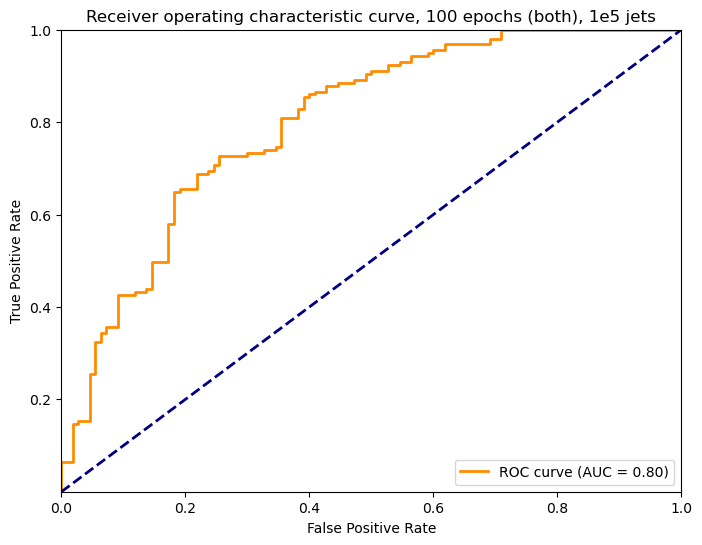

In [16]:
fpr, tpr, thresholds = roc_curve(labels_net, output_net) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve, 100 epochs (both), 1e5 jets')
plt.legend(loc="lower right")
plt.show()

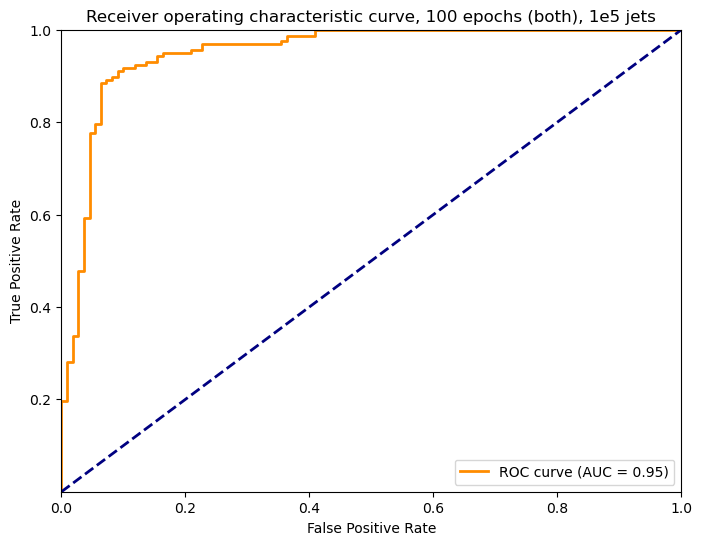

In [33]:
fpr, tpr, thresholds = roc_curve(labels_net, output_net) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve, 100 epochs (both), 1e5 jets')
plt.legend(loc="lower right")
plt.show()

In [20]:
print(torch.__version__)

1.11.0


# AE

## Loading Data 

In [11]:

class My_Dataset_diff(Dataset):
    def __init__(self, training_path , validation_path, test_path, usage, transform=None, target_transform=None, number_of_jets = None,event_kind = None):
        #getting data
        num_jets = number_of_jets
        if number_of_jets == None:
            num_jets = args.n_jets
        
        train_data , train_labels = converter_diff(training_path,int( num_jets),event_kind )
        #val_data , val_labels = converter(validation_path, int(num_jets*args.ratio) ) # for larger datasets below two time *args.ratio in the LCT part!
        #test_data, test_labels = converter(test_path,int(num_jets*args.ratio))
        val_data , val_labels = converter_diff(validation_path, int(num_jets),event_kind )
        test_data, test_labels = converter_diff(test_path,int(num_jets),event_kind)
        
        # re-scale test data, for the training data this will be done on the fly due to the augmentations
        test_data = rescale_pts( test_data )
        val_data = rescale_pts(val_data)

        if usage== "training" :
            self.labels = train_labels
            self.data = train_data
        elif usage=="validation":
            self.labels = val_labels
            self.data = val_data
        elif usage=="testing":
            self.labels = test_labels
            self.data = test_data
        else:
            print("check usage!")

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]

        return data, label
    

def converter_diff(data_path,num_jets,event_kind):

    data_frame = pd.read_hdf(data_path, key='table', start=0)
    #give names
    max_const = args.n_constit
    feat_list =  ["E","PX","PY","PZ"] 
    cols = ["{0}_{1}".format(feature,constit) for feature in feat_list for constit in range(max_const)]

    #read out the interest events
    if event_kind == 'QCD':
        data_frame = data_frame.query('is_signal_new == 0')
    elif event_kind == 'TOP':
        data_frame = data_frame.query('is_signal_new == 1')
    else:
        print('Check kind of Event')

    data_frame = data_frame[:num_jets]
    #reshape
    vec4 = np.expand_dims(data_frame[cols],axis=-1).reshape(-1, len(feat_list), max_const)
    #getting p_vec and E
    E  = vec4[:,0,:]
    pxs   = vec4[:,1,:]
    pys   = vec4[:,2,:]
    pzs   = vec4[:,3,:]
    # get pT,eta,phi
    pTs = pT(pxs,pys)
    etas = eta(pTs,pzs)
    phis = phi(pxs,pys)

    for i in range(etas.shape[0]):
        etas[i,:], phis[i,:] = centre_jet( etas[i,:], phis[i,:], pTs[i,:] )

    #get them together

    jet_data = np.stack([pTs,etas,phis],axis = 1)
    labels = data_frame["is_signal_new"].to_numpy()
    return torch.Tensor(jet_data).to(device) , torch.Tensor(labels).to(device)

#### Loading Model

In [115]:
loading_model = True
if loading_model :
    # Create an instance of your model
    net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )

    # Load the saved state dictionary
    state_dict = torch.load("/remote/gpu05/rueschkamp/outputs_from_queue/CLR/Big_Model.pt")

    # Load the state dictionary into the model
    net.load_state_dict(state_dict)
    net.to(device)
    net.eval()

#### Creating DL

In [196]:
#Dataloader Setup

data_AE_train = My_Dataset_diff(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"training",number_of_jets= 1e3,event_kind ='QCD')
data_AE_train_Top = My_Dataset_diff(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"training",number_of_jets= 1e3,event_kind ='TOP')
data_AE_test = My_Dataset(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"testing",number_of_jets= 1e3)

print(len(data_AE_test))

dl_AE_training = DataLoader(data_AE_train,batch_size=128, shuffle=True)
dl_AE_training_Top = DataLoader(data_AE_train_Top,batch_size=128, shuffle=True)
dl_AE_test = DataLoader(data_AE_test,batch_size=128, shuffle=False)

1000


### Checking stuff

#### Plotting Norm

torch.Size([128, 1000])
torch.Size([128])


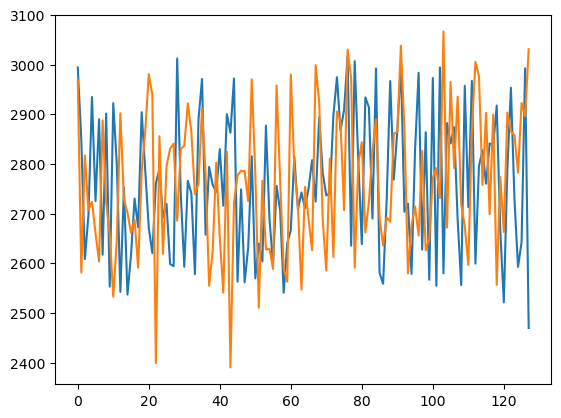

In [141]:
for i, (inputs, labels) in enumerate(dl_AE_training):
    #preprocess
    x_i = inputs
    time1 = time.time()
    x_i = x_i.transpose(1,2) #this should not be a thing lol WTF ______-----____
    point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
    break

for i, (inputs, labels) in enumerate(dl_AE_training_Top):
    #preprocess
    x_i = inputs
    time1 = time.time()
    x_i = x_i.transpose(1,2) #this should not be a thing lol WTF ______-----____
    point_on_sphere_top = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
    break

print(point_on_sphere.shape)
# Compute norm
norm = torch.norm(point_on_sphere,dim=1).to(torch.device("cpu"))
norm_top = torch.norm(point_on_sphere_top,dim=1).to(torch.device("cpu"))
print(norm.shape)
# Convert to numpy array
norm_array = norm.detach().numpy()
norm_array_top = norm_top.detach().numpy()

# Plot values

plt.plot(norm_array)
plt.plot(norm_array_top)
plt.show()


#### Angles

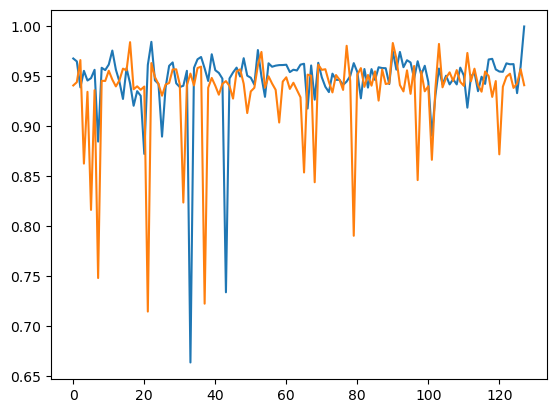

In [188]:
same_angles =torch.nn.functional.cosine_similarity(point_on_sphere[i], point_on_sphere, dim=1)
diff_angles =torch.nn.functional.cosine_similarity(point_on_sphere[i], point_on_sphere_top, dim=1)


# Plot values

same_a = same_angles.to(torch.device("cpu"))
diff_a = diff_angles.to(torch.device("cpu"))

plt.plot(same_a.detach().numpy())
plt.plot(diff_a.detach().numpy())
plt.show()

## Creating AE and train

In [124]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 8)
        )
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1000),
            #nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder()
model.to(device);

In [193]:
import collections
from tqdm import tqdm, tqdm_notebook # for the progress bar

criterion=nn.MSELoss()
learning_rate = 1e-3
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

def train(epochs, model, model_loss,train_dataloader):
    try: c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):
        epoch_loss = 0.0
        num_batches = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            #preprocess
            x_i = inputs
            time1 = time.time()
            x_i = x_i.transpose(1,2) #this should not be a thing lol WTF ______-----____
            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )



            outputs = model(point_on_sphere)
            loss = criterion(outputs, point_on_sphere)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(loss.item())
        t = time.time()
        #print(f"Epoch {epoch}: loss={epoch_loss:.4f} time taken{round(t1-t,2)}")

epochs = 10

train(model =model , epochs = epochs, model_loss =model_loss,train_dataloader=dl_AE_training)



/tmp/ipykernel_3579590/3150952226.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):


  0%|          | 0/10 [00:00<?, ?it/s]

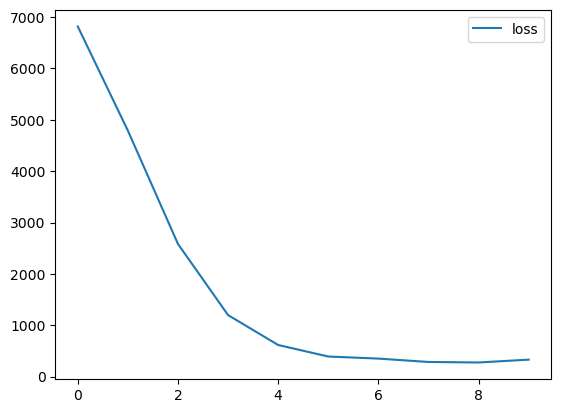

In [194]:
x = np.linspace(0, epochs-1 , epochs)
plt.plot(x, model_loss.loss, label="loss")
plt.legend()

## Evaluate

In [244]:
dl_AE_test = DataLoader(data_AE_test,batch_size=1, shuffle=False)


criterion =nn.MSELoss()

def calculate_errors(model, criterion, dataloader):
    errors = []
    model.eval() # set model to evaluation mode

    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, label in dataloader:
            x_i = inputs

            x_i =  x_i.transpose(1,2)

            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
            outputs = model(point_on_sphere)
            #print(point_on_sphere.shape)
            #outputs = sigmoid(model(point_on_sphere))
            for i in range(len(point_on_sphere)):
                
                loss = criterion(outputs[i], point_on_sphere[i]) 
                errors.extend([loss.to(torch.device("cpu")).numpy()])

    return np.array(errors)

def get_true_labels(data_loader):
    labels = []
    for batch in data_loader:
        _, batch_labels = batch
        labels.extend(batch_labels.to(torch.device("cpu")).numpy().tolist())
    return np.array(labels)

output_net = calculate_errors(model ,criterion, dl_AE_test)
labels_net = get_true_labels(dl_AE_test)

print(output_net)
print(labels_net)

[0.01775706 0.0174019  0.02536986 0.01635784 0.02360659 0.02582255
 0.02202654 0.0199843  0.01760305 0.02798522 0.04136802 0.03544677
 0.01628987 0.01681845 0.04864946 0.02040087 0.02000806 0.01734615
 0.03916092 0.01241656 0.0195182  0.02081297 0.03240323 0.03303441
 0.03373174 0.0203392  0.0225778  0.0299047  0.01924499 0.04979104
 0.01424061 0.01945599 0.02259899 0.03005079 0.023902   0.02206355
 0.01732131 0.01796791 0.01759285 0.02381131 0.01126463 0.02298636
 0.02131948 0.0460116  0.03121679 0.01818125 0.02239643 0.02557006
 0.04637024 0.02834434 0.0319556  0.05249864 0.02766403 0.01878931
 0.02567819 0.01931776 0.01617065 0.01629153 0.05294044 0.03313761
 0.04672223 0.02572069 0.01714798 0.02228227 0.01705663 0.01391727
 0.01115949 0.03030854 0.01639813 0.01331756 0.02262972 0.01853938
 0.02575772 0.01995442 0.02292808 0.03841642 0.01446444 0.01902644
 0.02570836 0.01850349 0.01368808 0.01617306 0.01601973 0.02892932
 0.01412012 0.01354488 0.02156755 0.01535969 0.01436189 0.0207

###### Random Test

In [252]:
dl_AE_test = DataLoader(data_AE_test,batch_size=1, shuffle=False)


criterion =nn.MSELoss()

def calculate_errors(model, criterion, dataloader):
    errors = []
    model.eval() # set model to evaluation mode

    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, label in dataloader:
            if label == 0:
                x_i = inputs
                #print("da")
            else:
                x_i = torch.rand([1,3,50])
                x_i =x_i.to(device)
                #print("dfw")

            x_i =  x_i.transpose(1,2)

            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
            outputs = model(point_on_sphere)
            #print(point_on_sphere.shape)
            #outputs = sigmoid(model(point_on_sphere))
            for i in range(len(point_on_sphere)):
                
                loss = criterion(outputs[i], point_on_sphere[i]) 
                errors.extend([loss.to(torch.device("cpu")).numpy()])

    return np.array(errors)

def get_true_labels(data_loader):
    labels = []
    for batch in data_loader:
        _, batch_labels = batch
        labels.extend(batch_labels.to(torch.device("cpu")).numpy().tolist())
    return np.array(labels)

output_net = calculate_errors(model ,criterion, dl_AE_test)
labels_net = get_true_labels(dl_AE_test)

print(output_net)
print(labels_net)

[ 0.32841986  0.3260614   0.33616713  0.3251736   0.33510962  0.33200097
  0.32880577  0.33015764  0.32589778  0.34260073  0.35876548  0.34466445
  0.3324107   0.3280615   0.35805583  0.3348481   0.32888994  0.32788065
  0.3581838   0.3227246   0.33050936  0.3315726   0.34230304  0.3511183
  0.33843654  0.32644436  0.32838786  0.33625087  0.33216506  0.36018783
 14.558388   13.210048   11.567005   13.609151   12.861294   12.671284
 11.178762   10.837286   10.29803    13.348826    0.31799084  0.33338255
  0.3290879   0.36403808  0.33996522  0.32872686  0.33217415  0.33525696
  0.35617217  0.3383819   0.34081197  0.3582499   0.33752206  0.3282624
  0.33509132  0.32871458  0.32870078  0.3326356   0.3624173   0.34843758
  9.097801   13.876245   10.499641    9.382545   15.144061   12.574632
 14.440086   10.643778   10.829381   14.632359   10.862867   11.366376
 10.372617   10.546055    9.277999   13.205411   16.165674    8.781676
 12.164864   10.561592   11.383356    9.7037945   9.190478   

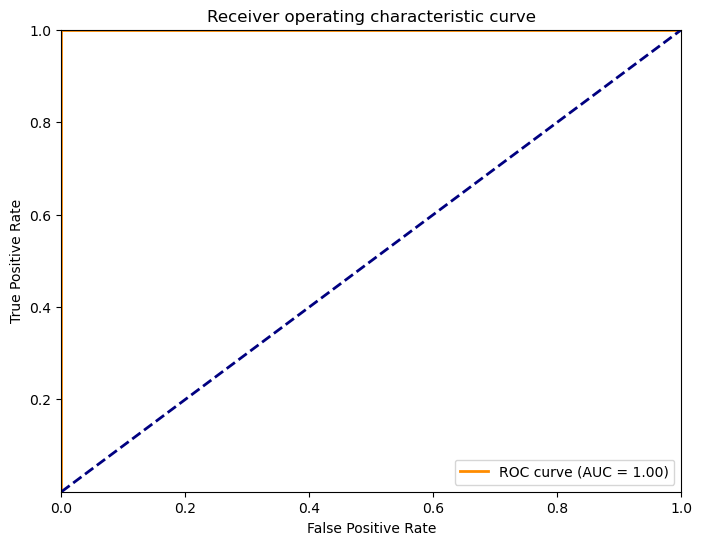

In [243]:
fpr, tpr, thresholds = roc_curve(labels_net, output_net) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# Checking

## Training only on QCD

In [246]:
#Dataloader Setup

data_AE_train = My_Dataset_diff(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"training",number_of_jets= 1e4,event_kind ='QCD')
data_AE_train_Top = My_Dataset_diff(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"training",number_of_jets= 1e3,event_kind ='TOP')
data_AE_test = My_Dataset(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"testing",number_of_jets= 1e3)

print(len(data_AE_test))

dl_AE_training = DataLoader(data_AE_train,batch_size=128, shuffle=True)
dl_AE_training_Top = DataLoader(data_AE_train_Top,batch_size=128, shuffle=True)
dl_AE_test = DataLoader(data_AE_test,batch_size=1, shuffle=False)

1000


#### Training loop for CLR

In [ ]:
# THE TRAINING LOOP -----------------------------------------------------------


#initializing the network 
input_dim = 3 

Qcd_net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )
# send network to device
Qcd_net.to( device )







print( "starting training loop, running for " + str( args.n_epochs ) + " epochs"    )
print( "---"    )

losses = []

# the loop
#for epoch in range( args.n_epochs ):
for epoch in range( 100):
    # initialise timing stats
    te0 = time.time()
    
    # initialise lists to store batch stats
    loss_align_e = []
    loss_uniform_e = []
    losses_e = []

    # initialise timing stats
    td1 = 0
    td2 = 0
    td3 = 0
    td4 = 0
    td5 = 0
    td6 = 0
    td7 = 0
    td8 = 0
    print("epoch: ",epoch)

    # the inner loop goes through the dataset batch by batch
    # augmentations of the jets are done on the fly
    for i, (data, labels) in enumerate(dl_AE_training): # here i changed to only QCD -----------------------------------------
        Qcd_net.optimizer.zero_grad()
        x_i = data
        
        
        time1 = time.time()
        # print(x_i.shape) # checking what Tensor is fed into the augmentations
        #x_i = rotate_jets( x_i )
        x_j = x_i.clone()
        if args.rot:
            x_j = rotate_jets( x_j )
        time2 = time.time()

        if (args.cf) == False :
            x_j = collinear_fill_jets_new( x_j )
            x_j = collinear_fill_jets_new( x_j ) #Why two times?
        time3 = time.time()

        if args.ptd:
            x_j = distort_jets( x_j, strength=args.ptst, pT_clip_min=args.ptcm )
        time4 = time.time()

        if args.trs:
            x_j = translate_jets( x_j, width=args.trsw )
            x_i = translate_jets( x_i, width=args.trsw ) # Why are both translated?
        time5 = time.time()
        
        x_i = rescale_pts( x_i )
        x_j = rescale_pts( x_j )
        x_i = x_i.transpose(1,2)
        x_j = x_j.transpose(1,2)
        time6 = time.time()

        z_i  = Qcd_net(x_i, use_mask=args.mask, use_continuous_mask=False) #dim: x_i = torch.Size([104, 50, 3]) and z_i = torch.Size([104, 1000])
        z_j = Qcd_net(x_j, use_mask=args.mask, use_continuous_mask=False)
        time7 = time.time()


        # compute the loss, back-propagate, and update scheduler if required
        loss = contrastive_loss( z_i, z_j, args.temperature ).to( device )
        loss.backward()
        Qcd_net.optimizer.step()
        losses_e.append( loss.detach().cpu().numpy() )
        
        time9 = time.time()

        # update timiing stats
        td1 += time2 - time1
        td2 += time3 - time2
        td3 += time4 - time3
        td4 += time5 - time4
        td5 += time6 - time5
        td6 += time7 - time6
        td7 += time8 - time7
        td8 += time9 - time8

    loss_e = np.mean( np.array( losses_e ) )
    losses.append( loss_e )


#np.save("/remote/gpu05/rueschkamp/outputs_from_queue/CLR/clr_losses.npy", losses )

print(x_j.shape )
print(z_j.shape )

te1= time.time()

print( "JETCLR TRAINING DONE, time taken: " + str( np.round( te1-te0 , 2 ) )    )
print( f"total time taken: {round( te1-te0, 1 )}s, augmentation: {round(td1+td2+td3+td4+td5,1)}s, forward {round(td6, 1)}s, backward {round(td8, 1)}s, other {round(te1-te0-(td1+td2+td3+td4+td6+td7+td8), 2)}s", flush=True, file=logfile )
print("collinier Fill: " + str( np.round( td2 , 2 )))

tms0 = time.time()
#torch.save(Qcd_net.state_dict(),"/remote/gpu05/rueschkamp/outputs_from_queue/CLR/Debugging/QCD_Net.pt")
tms1 = time.time()
print( f"time taken to save model: {round( tms1-tms0, 1 )}s" )


starting training loop, running for 100 epochs
---
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
ep

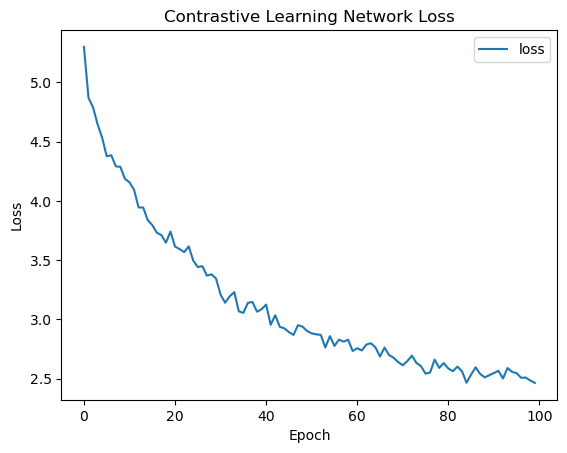

In [ ]:
# Plot the training loss
x = np.linspace(0,100-1,100)

plt.plot(x, losses, label = "loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Contrastive Learning Network Loss')
plt.legend()
plt.show()

#### AE

In [248]:
import collections
from tqdm import tqdm, tqdm_notebook # for the progress bar


Qcd_net.eval()
model=Autoencoder()
model.to(device)

criterion=nn.MSELoss()
learning_rate = 1e-3
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

def train(epochs, model, model_loss,train_dataloader):
    try: c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):
        epoch_loss = 0.0
        num_batches = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            #preprocess
            x_i = inputs
            time1 = time.time()
            x_i = x_i.transpose(1,2) #this should not be a thing lol WTF ______-----____
            point_on_sphere = Qcd_net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )



            outputs = model(point_on_sphere)
            loss = criterion(outputs, point_on_sphere)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(loss.item())
        t = time.time()
        print(f"Epoch {epoch}: loss={epoch_loss:.4f} time taken{round(t1-t,2)}")

epochs = 10

train(model =model , epochs = epochs, model_loss =model_loss,train_dataloader=dl_AE_training) #AE

/tmp/ipykernel_3579590/4134112391.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: loss=760.6697 time taken-5803.78
Epoch 1: loss=86.7821 time taken-5826.38
Epoch 2: loss=87.0097 time taken-5848.97
Epoch 3: loss=86.2021 time taken-5871.56
Epoch 4: loss=87.1165 time taken-5894.14
Epoch 5: loss=87.2106 time taken-5916.65
Epoch 6: loss=86.5896 time taken-5939.14
Epoch 7: loss=86.5548 time taken-5961.63
Epoch 8: loss=86.7329 time taken-5984.15
Epoch 9: loss=86.3241 time taken-6006.71


In [253]:
dl_AE_test = DataLoader(data_AE_test,batch_size=1, shuffle=False)


criterion =nn.MSELoss()

def calculate_errors(model, criterion, dataloader):
    errors = []
    model.eval() # set model to evaluation mode

    with torch.no_grad(): # turn off gradients since we're only evaluating
        for inputs, label in dataloader:
            x_i = inputs

            x_i =  x_i.transpose(1,2)

            point_on_sphere = net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
            outputs = model(point_on_sphere)
            #print(point_on_sphere.shape)
            #outputs = sigmoid(model(point_on_sphere))
            for i in range(len(point_on_sphere)):
                
                loss = criterion(outputs[i].unsqueeze(0), point_on_sphere[i].unsqueeze(0)) 
                errors.extend([loss.to(torch.device("cpu")).numpy()])

    return np.array(errors)

def get_true_labels(data_loader):
    labels = []
    for batch in data_loader:
        _, batch_labels = batch
        labels.extend(batch_labels.to(torch.device("cpu")).numpy().tolist())
    return np.array(labels)

output_net = calculate_errors(model ,criterion, dl_AE_test)
labels_net = get_true_labels(dl_AE_test)

print(output_net)
print(labels_net)

[0.32970968 0.32546985 0.33684742 0.32471767 0.33354944 0.33174703
 0.32914028 0.33140993 0.3255781  0.3401844  0.35765275 0.3469355
 0.33218876 0.32803404 0.36637002 0.33384055 0.326856   0.32727656
 0.35835722 0.32334343 0.3288321  0.33056727 0.34080085 0.35220876
 0.33610702 0.3302258  0.33015114 0.33827063 0.332641   0.3584003
 0.32325646 0.3276455  0.33294326 0.341145   0.33387148 0.32935026
 0.32611814 0.3278721  0.32566628 0.33082646 0.31793892 0.33245254
 0.3283182  0.36103663 0.33941904 0.33053932 0.33358857 0.334073
 0.3543851  0.33838928 0.33995968 0.35435182 0.33743018 0.32914248
 0.33581507 0.3290741  0.3292207  0.33156782 0.36401752 0.34965596
 0.35559464 0.33784077 0.32534054 0.33112815 0.326633   0.32285634
 0.31761387 0.337147   0.32547882 0.32433048 0.33234748 0.3267512
 0.33300197 0.32719654 0.3320487  0.3462869  0.32314783 0.32722786
 0.33383945 0.3269945  0.32501018 0.32566488 0.32469964 0.337398
 0.3227613  0.32295966 0.33197823 0.32576472 0.32407635 0.32892916
 0

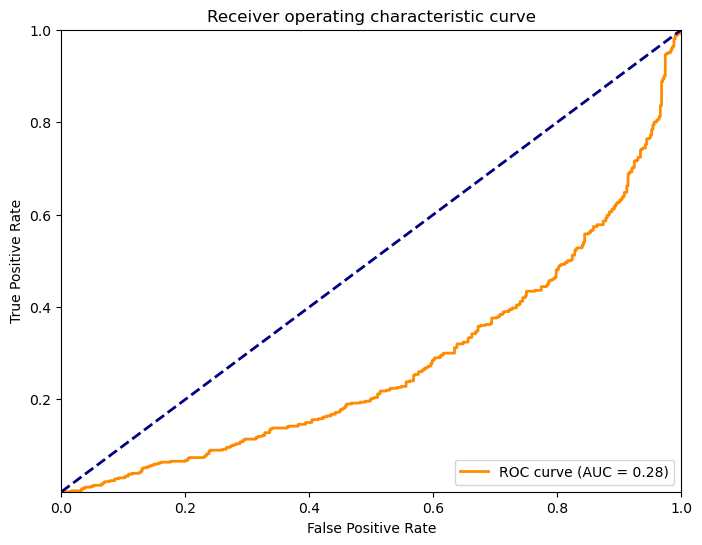

In [254]:
fpr, tpr, thresholds = roc_curve(labels_net, output_net) #getting the data needed to plot the ROC curve
roc_auc = auc(fpr, tpr) #getting the AUC
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([1e-4, 1.0])  # set the lower limit to 0.0001 for logarithmic y-axis
plt.xscale('linear')     # set x-axis to linear scale
#plt.yscale('log')        # set y-axis to logarithmic scale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

### Plotting Norm

torch.Size([128, 1000])
torch.Size([128])


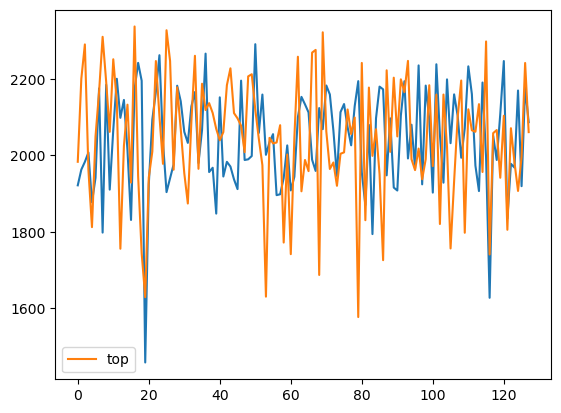

In [257]:
Qcd_net.eval()
for i, (inputs, labels) in enumerate(dl_AE_training):
    #preprocess
    x_i = inputs
    time1 = time.time()
    x_i = x_i.transpose(1,2) #this should not be a thing lol WTF ______-----____
    point_on_sphere = Qcd_net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
    break

for i, (inputs, labels) in enumerate(dl_AE_training_Top):
    #preprocess
    x_i = inputs
    #x_i = torch.rand([128,3,50]).to(device)
    time1 = time.time()
    x_i = x_i.transpose(1,2) #this should not be a thing lol WTF ______-----____
    point_on_sphere_top = Qcd_net(x_i, use_mask=args.mask, use_continuous_mask=args.cmask )
    break

print(point_on_sphere.shape)
# Compute norm
norm = torch.norm(point_on_sphere,dim=1).to(torch.device("cpu"))
norm_top = torch.norm(point_on_sphere_top,dim=1).to(torch.device("cpu"))
print(norm.shape)
# Convert to numpy array
norm_array = norm.detach().numpy()
norm_array_top = norm_top.detach().numpy()

# Plot values

plt.plot(norm_array)
plt.plot(norm_array_top,label="top")
plt.legend()
plt.show()

#### Testing Random Jet in AE

p